# BAX423 Homework 4

## The Analyst Amigos: Vaaridhi Mathur, Rahul Rajput, Xingyi (Stella) Wang, Jinying (Jinny) Zhong

In [60]:
# Run below commands
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz
!tar xf spark-3.0.3-bin-hadoop3.2.tgz
!pip install -q findspark

In [61]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"

In [62]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from datetime import datetime, date, timedelta
from dateutil import relativedelta
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.functions import to_timestamp, to_date, dayofmonth
from pyspark.sql import functions as F  
from pyspark.sql.functions import collect_list, collect_set, concat, first, array_distinct, col, size, expr
from pyspark.sql import DataFrame 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import random

# Text Analytics


## Q0 [5 pts]: Your first task is to open your Venmo app, find 10 words that are not already in the dictionary and add them to it. Make sure you don’t add to the dictionary a duplicate word by hitting Control+F before adding your word.

**We did not directly add these words in the google sheet. Those 10 words is added to the copy of shared documents.**

1. profile-People; <br>
2. pickup-Activity;  <br>
3. san mateo-Activity;  <br>
4. hihi-People;  <br>
5. yumyum-Food;  <br>
6. sofa-Utility;  <br>
7. 5guy-Food;  <br>
8. additional-Cash;  <br>
9. tofu soup-Food; <br>
10. shipment-Utility

In [63]:
# #To use if needed
# from google.colab import drive
# drive.mount('/content/drive')

## Q1 [5 pts]: Use the text dictionary and the emoji dictionary to classify Venmo’s transactions in your sample dataset.

In [64]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
import emoji

# Initialize Spark session
#spark = SparkSession.builder.master("local").appName("Venmo").getOrCreate()

spark = SparkSession.builder.master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.8.1-spark3.0-s_2.12").appName("Venmo").getOrCreate()

sample_df = spark.read.parquet("/content/drive/Shareddrives/Big Data Project/Homework/Venmo HW/VenmoSample.snappy.parquet")
text_dictionary_df = spark.read.csv("/content/drive/Shareddrives/Big Data Project/Homework/Venmo HW/NewVenmo Word Classification Dictonary - Word_Dict.csv", header=True)
emoji_dictionary_df = spark.read.csv("/content/drive/Shareddrives/Big Data Project/Homework/Venmo HW/Venmo_Emoji_Classification_Dictionary.csv", header=True)

In [66]:
num_rows = sample_df.count()
print("Number of rows: ", num_rows)

Number of rows:  7113137


**We choose 1% of the data as sample data**

In [67]:
sample_df_1 = sample_df.sample(False, 0.01, seed=42) # change the percentage here

In [68]:
sample_df_1.take(3)

[Row(user1=6471126, user2=10046265, transaction_type='charge', datetime=datetime.datetime(2016, 5, 18, 8, 0, 50), description='Butterfinger mklk', is_business=False, story_id='573bbec2cd03c9af22d27811'),
 Row(user1=4892258, user2=5697557, transaction_type='payment', datetime=datetime.datetime(2016, 4, 30, 3, 25, 17), description='🍕 Mary had a little lamb', is_business=False, story_id='5723c32dcd03c9af22160da3'),
 Row(user1=1718828, user2=353851, transaction_type='payment', datetime=datetime.datetime(2015, 10, 2, 8, 2, 23), description='Thank you', is_business=False, story_id='560dd79fcd03c9af223f674f')]

In [69]:
text_dictionary_df.take(3)

[Row(People='friend', Food='food', Event='birthday', Activity='ball', Travel='beach', Transportation='lyft', Utility='bill', Cash='atm ', Illegal/Sarcasm='addiction'),
 Row(People='friendship', Food='bbq', Event='christmas', Activity='boat', Travel='place', Transportation='uber', Utility='cable', Cash='bank ', Illegal/Sarcasm='drug'),
 Row(People='baby', Food='bean', Event='happy', Activity='bar', Travel='la', Transportation='cab', Utility='fee', Cash='cash ', Illegal/Sarcasm='wangs')]

In [70]:
emoji_dictionary_df.take(3)

[Row(Event='🇦🇺', Travel='🏔', Food='🍇', Activity='👾', Transportation='🚄', People='😀', Utility='⚡'),
 Row(Event='🇫🇷', Travel='⛰', Food='🍈', Activity='🕴', Transportation='🚅', People='😃', Utility='💡'),
 Row(Event='🎂', Travel='🌋', Food='🍉', Activity='🎪', Transportation='🚆', People='😄', Utility=' 🔌')]

In [71]:
print("Sample dataset schema:")
sample_df_1.printSchema()

print("Text dictionary schema:")
text_dictionary_df.printSchema()

print("Emoji dictionary schema:")
emoji_dictionary_df.printSchema()


Sample dataset schema:
root
 |-- user1: integer (nullable = true)
 |-- user2: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- story_id: string (nullable = true)

Text dictionary schema:
root
 |-- People: string (nullable = true)
 |-- Food: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Activity: string (nullable = true)
 |-- Travel: string (nullable = true)
 |-- Transportation: string (nullable = true)
 |-- Utility: string (nullable = true)
 |-- Cash: string (nullable = true)
 |-- Illegal/Sarcasm: string (nullable = true)

Emoji dictionary schema:
root
 |-- Event: string (nullable = true)
 |-- Travel: string (nullable = true)
 |-- Food: string (nullable = true)
 |-- Activity: string (nullable = true)
 |-- Transportation: string (nullable = true)
 |-- People: string (nullable = true)
 |-- Utility: string (nul

In [72]:
# Reshaping the text_dictionary_df
columns = text_dictionary_df.columns
text_dictionary_long = text_dictionary_df.selectExpr("stack(9, 'People', People, 'Food', Food, 'Event', Event, 'Activity', Activity, 'Travel', Travel, 'Transportation', Transportation, 'Utility', Utility, 'Cash', Cash, 'Illegal/Sarcasm', `Illegal/Sarcasm`) as (category, word)")

# Reshaping the emoji_dictionary_df
columns = emoji_dictionary_df.columns
emoji_dictionary_long = emoji_dictionary_df.selectExpr("stack(7, 'People', People, 'Food', Food, 'Event', Event, 'Activity', Activity, 'Travel', Travel, 'Transportation', Transportation, 'Utility', Utility) as (category, emoji)")

In [73]:
# Joining the dataframes
sample_with_text_category = sample_df_1.join(text_dictionary_long, sample_df_1.description.contains(text_dictionary_long.word), 'left_outer')
sample_with_both_categories = sample_with_text_category.join(emoji_dictionary_long, sample_with_text_category.description.contains(emoji_dictionary_long.emoji), 'left_outer')

# Selecting relevant columns
final_df = sample_with_both_categories.select(sample_df_1["*"], text_dictionary_long["category"].alias("text_category"), emoji_dictionary_long["emoji"], emoji_dictionary_long["category"].alias("emoji_category"))


In [74]:
final_df.show(truncate=False)

+-------+--------+----------------+-------------------+-------------------------+-----------+------------------------+---------------+-----+--------------+
|user1  |user2   |transaction_type|datetime           |description              |is_business|story_id                |text_category  |emoji|emoji_category|
+-------+--------+----------------+-------------------+-------------------------+-----------+------------------------+---------------+-----+--------------+
|6471126|10046265|charge          |2016-05-18 08:00:50|Butterfinger mklk        |false      |573bbec2cd03c9af22d27811|null           |null |null          |
|4892258|5697557 |payment         |2016-04-30 03:25:17|🍕 Mary had a little lamb|false      |5723c32dcd03c9af22160da3|Travel         |🍕   |Food          |
|4892258|5697557 |payment         |2016-04-30 03:25:17|🍕 Mary had a little lamb|false      |5723c32dcd03c9af22160da3|People         |🍕   |Food          |
|4892258|5697557 |payment         |2016-04-30 03:25:17|🍕 Mary had a 

## Q2 [5 pts]: What is the percent of emoji only transactions? Which are the top 5 most popular emoji? Which are the top three most popular emoji categories?

**Answer:**

Percent of emoji only transactions: 23.71%.

Top 5 most popular emoji are: null,🍻, 🍕, 🎉, 🍷.

Top 3 most popular emoji categories are: null, Food, People.

In [75]:
# Emoji only transactions
emoji_only_count = final_df.filter(col("text_category").isNull() & col("emoji_category").isNotNull()).count()
total_count = final_df.count()
emoji_only_percent = (emoji_only_count / total_count) * 100

print(f"Percent of emoji only transactions: {emoji_only_percent:.2f}%")

# Top 5 most popular emoji
emoji_popularity = final_df.groupBy("emoji").agg(count("*").alias("count")).sort(desc("count")).limit(5)
print("Top 5 most popular emojis:")
emoji_popularity.show()

# Top 3 most popular emoji categories
emoji_category_popularity = final_df.groupBy("emoji_category").agg(count("*").alias("count")).sort(desc("count")).limit(3)
print("Top 3 most popular emoji categories:")
emoji_category_popularity.show()

Percent of emoji only transactions: 23.71%
Top 5 most popular emojis:
+-----+-----+
|emoji|count|
+-----+-----+
| null|73727|
|   🍻| 1225|
|   🍕| 1183|
|   🎉|  927|
|   🍷|  837|
+-----+-----+

Top 3 most popular emoji categories:
+--------------+-----+
|emoji_category|count|
+--------------+-----+
|          null|73727|
|          Food|13781|
|        People| 9595|
+--------------+-----+



## Q3 [5 pts]: For each user, create a variable to indicate their spending behavior profile. For example, if a user has made 10 transactions, where 5 of them are food and the other 5 are activity, then the user’s spending profile will be 50% food and 50% activity.

In [76]:
# Calculate the total number of transactions for each user
transaction_counts = final_df.groupBy("user1").count().withColumnRenamed("count", "total_transactions")

# Calculate the number of transactions per category for each user
category_counts = final_df.groupBy("user1", "text_category").count().withColumnRenamed("count", "category_transactions")

# Calculate the percentage of transactions per category for each user
profile_data = (
    category_counts
    .join(transaction_counts, on="user1", how="inner")
    .withColumn("percentage", col("category_transactions") / col("total_transactions") * 100)
    .drop("category_transactions", "total_transactions")
    .orderBy("user1", "text_category")
)

profile_data.show(truncate=False)


+-----+---------------+-----------------+
|user1|text_category  |percentage       |
+-----+---------------+-----------------+
|4    |Food           |50.0             |
|4    |Illegal/Sarcasm|50.0             |
|10   |Food           |100.0            |
|43   |null           |100.0            |
|52   |Activity       |25.0             |
|52   |Food           |25.0             |
|52   |People         |25.0             |
|52   |Utility        |25.0             |
|879  |Illegal/Sarcasm|33.33333333333333|
|879  |People         |33.33333333333333|
|879  |Transportation |33.33333333333333|
|1009 |null           |100.0            |
|1241 |Food           |100.0            |
|2504 |null           |100.0            |
|2794 |Food           |50.0             |
|2794 |Illegal/Sarcasm|50.0             |
|3310 |null           |100.0            |
|3664 |Food           |80.0             |
|3664 |Travel         |20.0             |
|4715 |Activity       |50.0             |
+-----+---------------+-----------

##  Q4 [5 pts]: What do you observe? Does the spending profile of the average customer stabilize after some point in time?



**Answer will list under the title of graphs and tables.**

In [77]:
from pyspark.sql.functions import datediff, floor, min, avg, stddev
from pyspark.sql.window import Window

# Find the first transaction date for each user
user_first_transaction_dates = final_df.groupBy("user1").agg(min("datetime").alias("first_transaction_date"))

# Add first transaction date to final_df
final_df_with_first_date = final_df.join(user_first_transaction_dates, on="user1", how="inner")

# Calculate the difference in days between the first transaction and each subsequent transaction
final_df_with_first_date = final_df_with_first_date.withColumn("days_since_first", datediff("datetime", "first_transaction_date"))

# Calculate the number of months since the first transaction (floor division by 30 to approximate months)
final_df_with_first_date = final_df_with_first_date.withColumn("months_since_first", floor(col("days_since_first") / 30))

# Remove data for months greater than 12
final_df_filtered = final_df_with_first_date.filter(col("months_since_first") <= 12)

# Calculate transactions per category for each user per month
category_counts_per_month = final_df_filtered.groupBy("user1", "text_category", "months_since_first").count().withColumnRenamed("count", "category_transactions")

# Calculate total transactions per user per month
transaction_counts_per_month = final_df_filtered.groupBy("user1", "months_since_first").count().withColumnRenamed("count", "total_transactions")

# Calculate the percentage of transactions per category for each user per month
profile_data_dynamic = (
    category_counts_per_month
    .join(transaction_counts_per_month, on=["user1", "months_since_first"], how="inner")
    .withColumn("percentage", col("category_transactions") / col("total_transactions") * 100)
    .drop("category_transactions", "total_transactions")
    .orderBy("user1", "text_category", "months_since_first")
)

# Calculate average and standard deviation of each spending category for each month across all users
avg_std_dev_per_month = (
    profile_data_dynamic
    .groupBy("text_category", "months_since_first")
    .agg(avg("percentage").alias("average"), stddev("percentage").alias("standard_deviation"))
    .orderBy("text_category", "months_since_first")
)

avg_std_dev_per_month.show(truncate=False)


+-------------+------------------+------------------+------------------+
|text_category|months_since_first|average           |standard_deviation|
+-------------+------------------+------------------+------------------+
|null         |0                 |99.86414676498812 |2.9068674370366465|
|null         |1                 |100.0             |0.0               |
|null         |2                 |100.0             |0.0               |
|null         |3                 |100.0             |0.0               |
|null         |4                 |100.0             |0.0               |
|null         |5                 |100.0             |0.0               |
|null         |6                 |100.0             |0.0               |
|null         |7                 |100.0             |0.0               |
|null         |8                 |100.0             |0.0               |
|null         |9                 |100.0             |0.0               |
|null         |10                |100.0            

In [78]:
final_df_filtered.show()

+------+-------+----------------+-------------------+--------------------+-----------+--------------------+-------------+-----+--------------+----------------------+----------------+------------------+
| user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|text_category|emoji|emoji_category|first_transaction_date|days_since_first|months_since_first|
+------+-------+----------------+-------------------+--------------------+-----------+--------------------+-------------+-----+--------------+----------------------+----------------+------------------+
| 29894|  33385|          charge|2013-03-09 07:30:36|              Pizza!|      false|513a75ec25ee44b9a...|         Food| null|          null|   2013-03-09 07:30:36|               0|                 0|
| 33602| 677386|         payment|2014-07-11 04:18:28|          Last night|      false|53bf03247d0b0354e...|     Activity| null|          null|   2014-07-11 04:18:28|               0|          

In [79]:
# Convert the Spark DataFrame to a Pandas DataFrame
avg_std_dev_per_month_pd = avg_std_dev_per_month.toPandas()

### 1. Plot of Spending Category over Time (y-axis percentage, x-axis month)

*The next plot follows the instruction of y-axis=Time and x-axis=spending percentage. I choose to use this graph to interpret, since it's easier to understand.*


**Observations:** 

As we can see from the graph blow, each spending category across all users fluctuates a lot over time. It seems that after month of 6, the spending profile of the average customer stabilize in time. 

Categories of Food, Transportation and Utility usually takes the largest proportion. (Has the highest percentage at a specfic time point) Event and Cash categories tend to have the lowest percentage overall.

For the Travel category, other than the month 5 and month 7 reach the its highest percentage point, this category does not fluctuate a lot on the other time.

(In order to have more details for each category, I generate plots for different time point, and the average percentage change table to interpret in the following steps.)


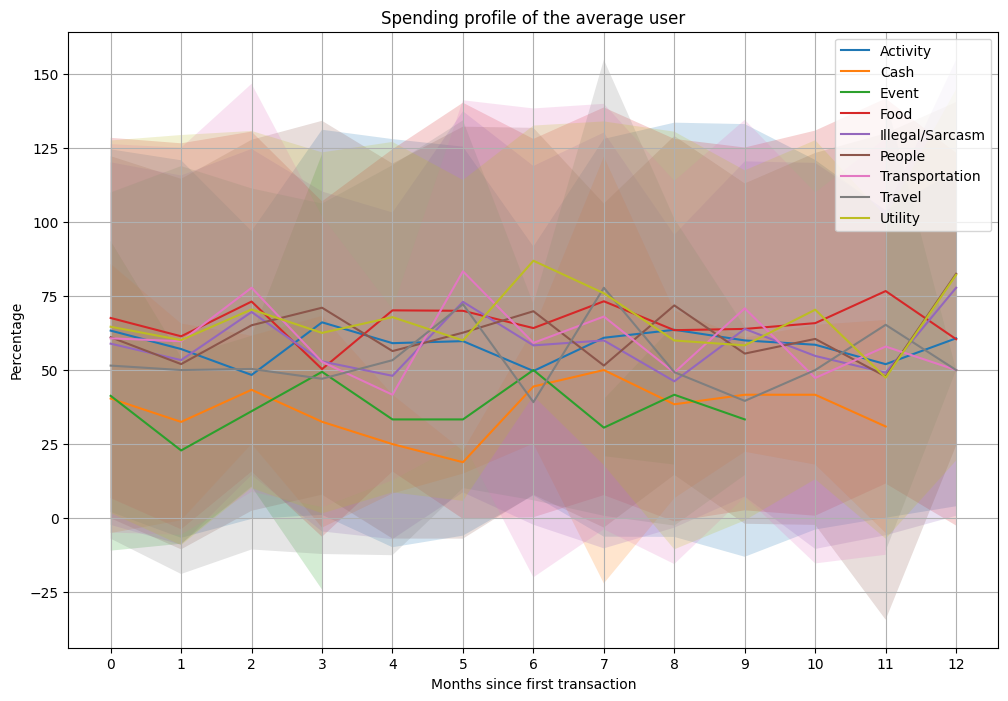

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Pivot DataFrame to have months_since_first as index, text_category as columns, and average as values
average_df = avg_std_dev_per_month_pd.pivot_table(index="months_since_first", columns="text_category", values="average")

# Pivot DataFrame to have months_since_first as index, text_category as columns, and standard_deviation as values
std_dev_df = avg_std_dev_per_month_pd.pivot_table(index="months_since_first", columns="text_category", values="standard_deviation")

# Plot the average for each category with confidence interval (+- 2 * standard deviation)
fig, ax = plt.subplots(figsize=(12, 8))

for column in average_df.columns:
    ax.plot(average_df.index, average_df[column], label=column)
    ax.fill_between(
        average_df.index,
        average_df[column] - 2 * std_dev_df[column],
        average_df[column] + 2 * std_dev_df[column],
        alpha=0.2
    )

ax.set_xlabel("Months since first transaction")
ax.set_ylabel("Percentage")
ax.set_title("Spending profile of the average user")
ax.legend()
plt.xticks(np.arange(0, 13, step=1))  # Set x-axis ticks to display every month from 0 to 12
plt.grid()
plt.show()


### 2. Plot of Spending Category over Time (x-axis percentage, y-axis month)

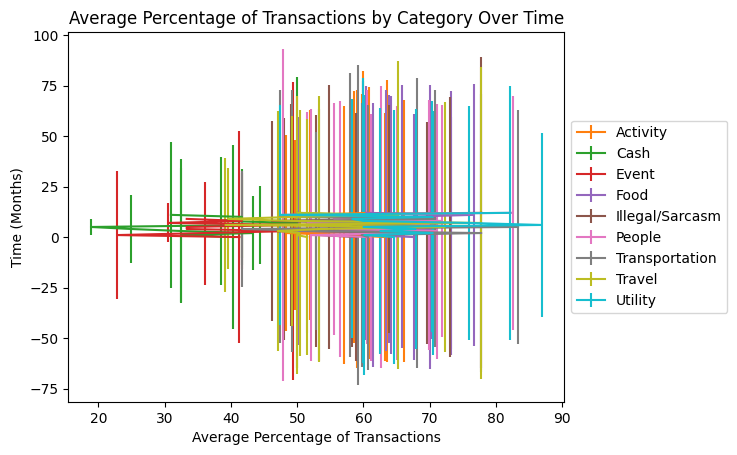

In [81]:
# Create a list of unique categories
categories = avg_std_dev_per_month_pd['text_category'].unique()

# Set up the figure and axes for the plot
fig, ax = plt.subplots()

# plot each category
for category in categories:
    # filter data for the category
    category_data = avg_std_dev_per_month_pd[avg_std_dev_per_month_pd['text_category'] == category]
    
    # plot average percentage with confidence interval for the category
    ax.errorbar(category_data['average'], category_data['months_since_first'], 
                yerr=2*category_data['standard_deviation'], label=category)

# add legend outside of plot area
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# label axes and add title
ax.set_xlabel('Average Percentage of Transactions')
ax.set_ylabel('Time (Months)')
ax.set_title('Average Percentage of Transactions by Category Over Time')

# display the plot
plt.show()


### 3. Average Percentage Change Table

**Observations:**

The People category has the highest average change through a year, which is 35.07%. Also, one notable thing is the Illegal/Sarcasm category increased a lot. This may need to do more analysis to get insights and have corresponding strategies to prevent that.

In [82]:
# Initialize the DataFrame
percentage_change_table = pd.DataFrame(columns=['text_category', 'percentage_change'])

for category in categories:
    # Filter data for the category
    category_data = avg_std_dev_per_month_pd[avg_std_dev_per_month_pd['text_category'] == category]
    
    # Ensure there is data for month 0 and month 12
    if 0 in category_data['months_since_first'].values and 12 in category_data['months_since_first'].values:
        # Calculate percentage change from month 0 to month 12
        percentage_change = ((category_data.loc[category_data['months_since_first'] == 12, 'average'].values[0] - 
                              category_data.loc[category_data['months_since_first'] == 0, 'average'].values[0]) /
                             category_data.loc[category_data['months_since_first'] == 0, 'average'].values[0]) * 100
    else:
        # If there is no data for month 0 or month 12, set percentage change to NaN
        percentage_change = np.nan
    
    # Append to the table
    percentage_change_table = percentage_change_table.append({'text_category': category, 
                                                              'percentage_change': percentage_change}, 
                                                             ignore_index=True)


<ipython-input-82-42d1e535ce81>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  percentage_change_table = percentage_change_table.append({'text_category': category,
<ipython-input-82-42d1e535ce81>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  percentage_change_table = percentage_change_table.append({'text_category': category,
<ipython-input-82-42d1e535ce81>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  percentage_change_table = percentage_change_table.append({'text_category': category,
<ipython-input-82-42d1e535ce81>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  percentage_change_table = percentage_change_table.append({'te

In [83]:
percentage_change_table

,text_category,percentage_change
0,NaN,NaN
1,Activity,-4.093673
2,Cash,NaN
3,Event,NaN
4,Food,-10.594748
5,Illegal/Sarcasm,32.032893
6,People,35.071671
7,Transportation,-17.646481
8,Travel,-2.921525
9,Utility,27.117235


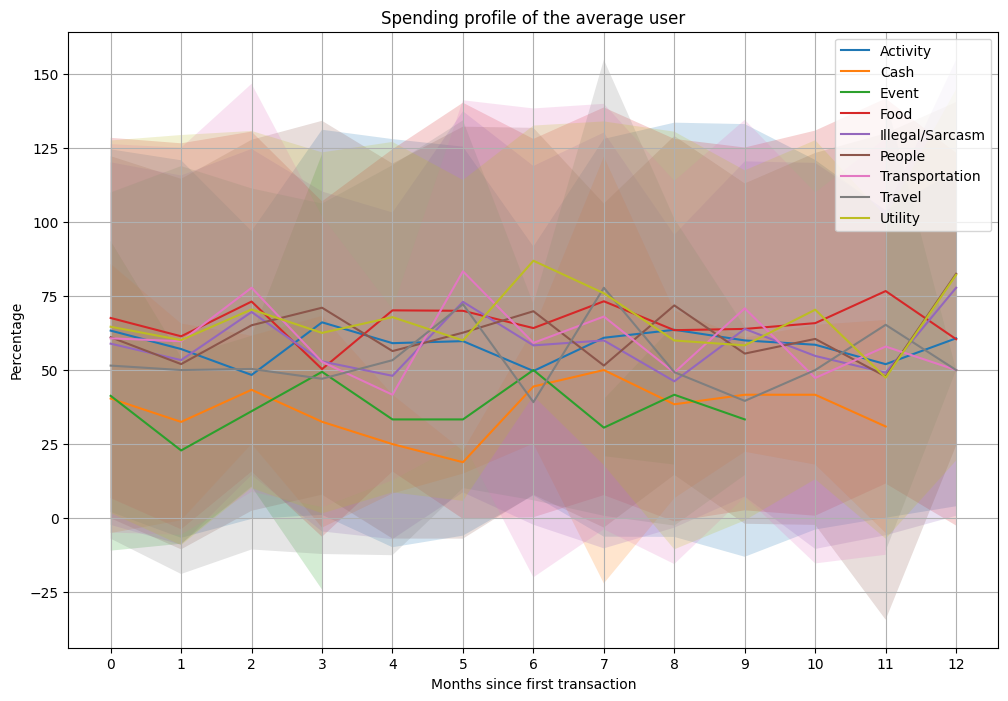

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Pivot DataFrame to have months_since_first as index, text_category as columns, and average as values
average_df = avg_std_dev_per_month_pd.pivot_table(index="months_since_first", columns="text_category", values="average")

# Pivot DataFrame to have months_since_first as index, text_category as columns, and standard_deviation as values
std_dev_df = avg_std_dev_per_month_pd.pivot_table(index="months_since_first", columns="text_category", values="standard_deviation")

# Plot the average for each category with confidence interval (+- 2 * standard deviation)
fig, ax = plt.subplots(figsize=(12, 8))

for column in average_df.columns:
    ax.plot(average_df.index, average_df[column], label=column)
    ax.fill_between(
        average_df.index,
        average_df[column] - 2 * std_dev_df[column],
        average_df[column] + 2 * std_dev_df[column],
        alpha=0.2
    )

ax.set_xlabel("Months since first transaction")
ax.set_ylabel("Percentage")
ax.set_title("Spending profile of the average user")
ax.legend()
plt.xticks(np.arange(0, 13, step=1))  # Set x-axis ticks to display every month from 0 to 12
plt.grid()
plt.show()


### 4. Average Percentage of Transactions for **EACH** Month

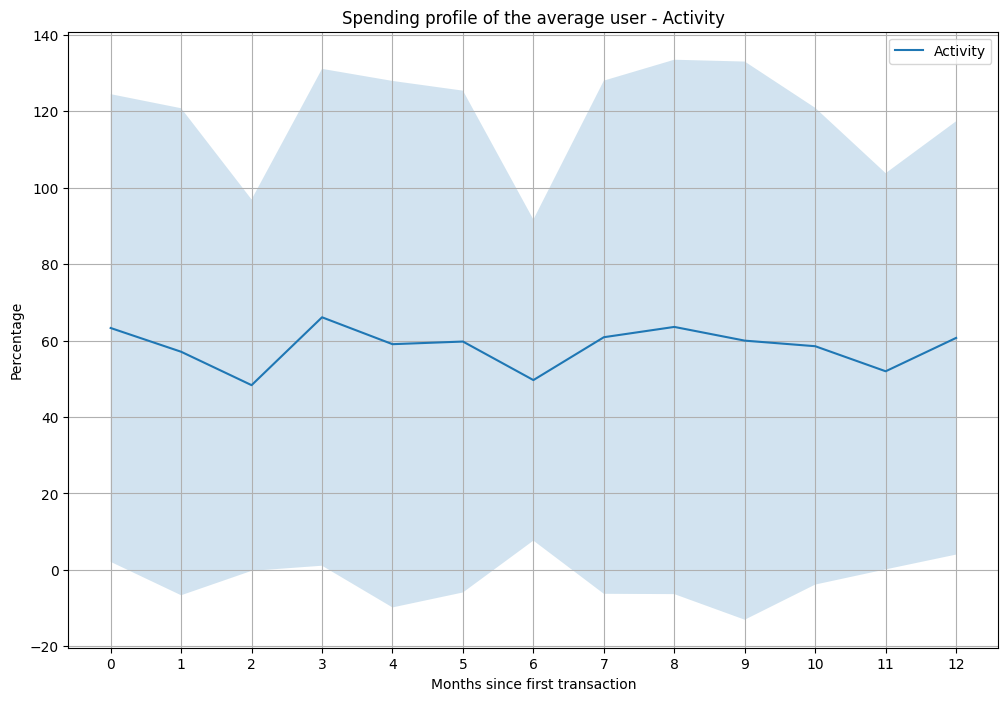

    months_since_first    average
13                   0  63.305819
14                   1  57.092593
15                   2  48.350340
16                   3  66.111111
17                   4  59.074074
18                   5  59.761905
19                   6  49.679487
20                   7  60.897436
21                   8  63.591270
22                   9  60.000000
23                  10  58.541667
24                  11  51.984127
25                  12  60.714286


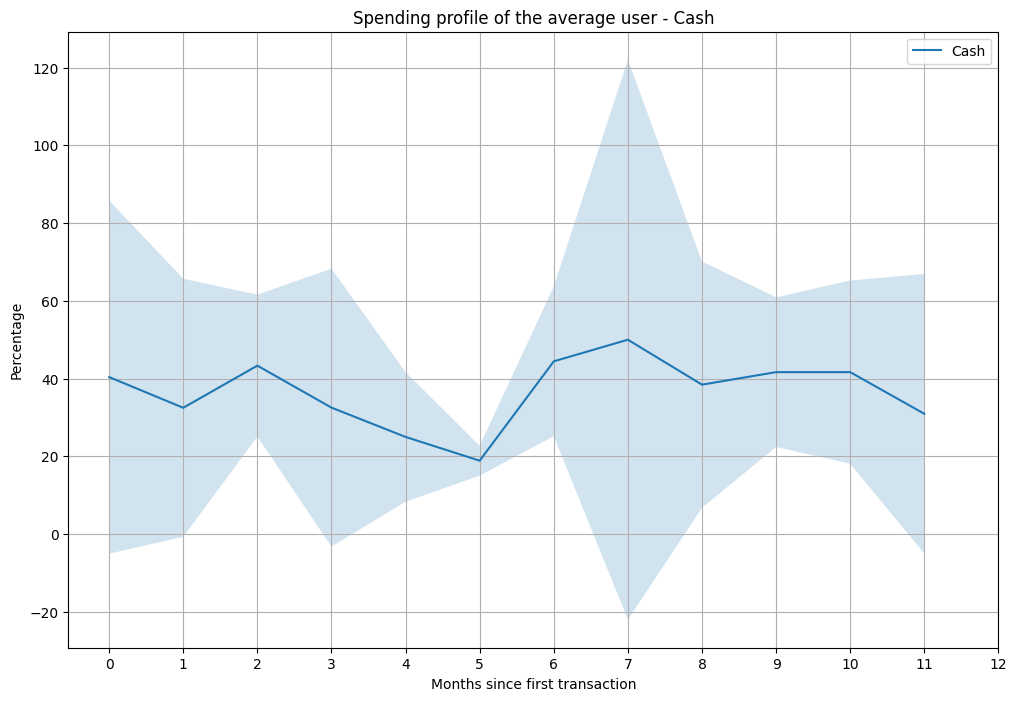

    months_since_first    average
26                   0  40.390196
27                   1  32.500000
28                   2  43.333333
29                   3  32.539683
30                   4  25.000000
31                   5  18.888889
32                   6  44.444444
33                   7  50.000000
34                   8  38.444444
35                   9  41.666667
36                  10  41.666667
37                  11  30.952381


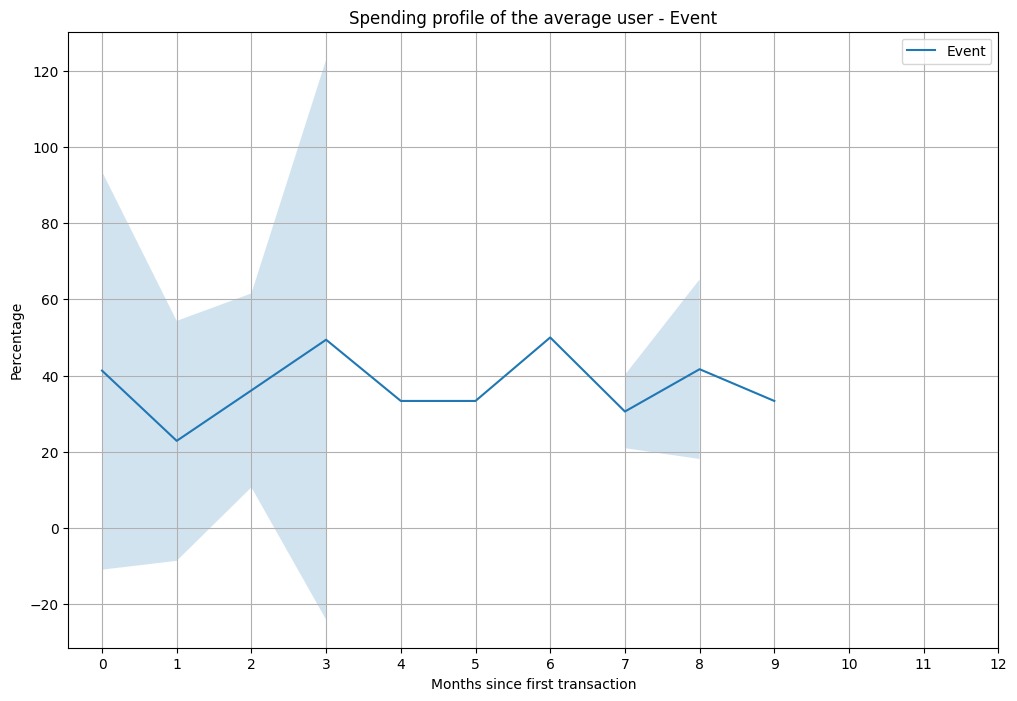

    months_since_first    average
38                   0  41.291558
39                   1  22.857143
40                   2  36.111111
41                   3  49.404762
42                   4  33.333333
43                   5  33.333333
44                   6  50.000000
45                   7  30.555556
46                   8  41.666667
47                   9  33.333333


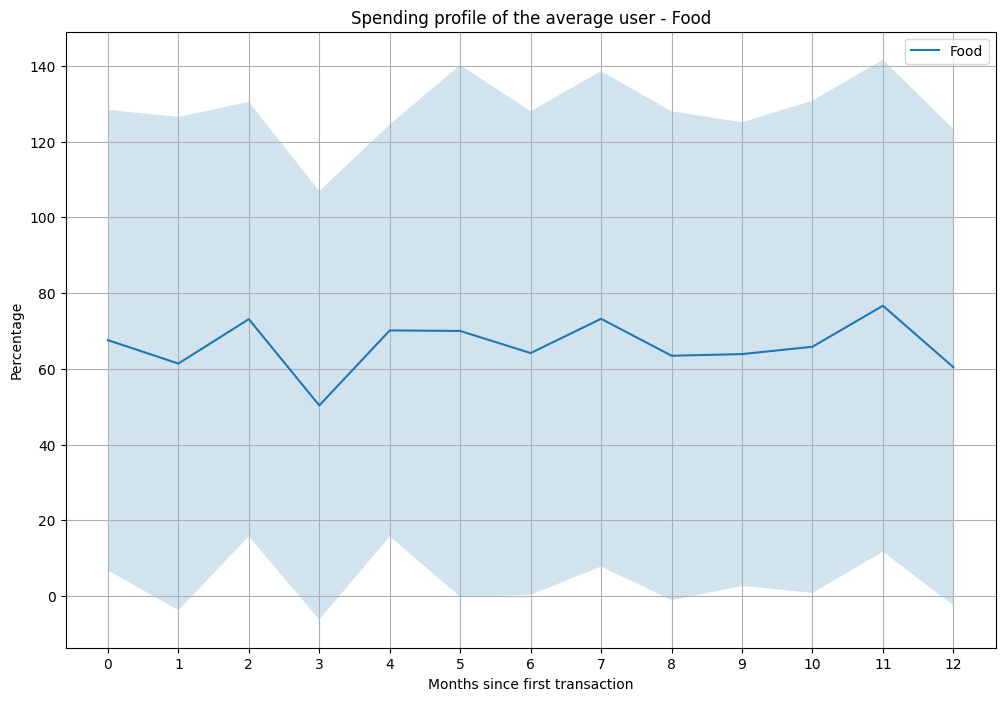

    months_since_first    average
48                   0  67.576195
49                   1  61.391723
50                   2  73.125000
51                   3  50.327381
52                   4  70.151515
53                   5  70.000000
54                   6  64.166667
55                   7  73.214286
56                   8  63.456790
57                   9  63.888889
58                  10  65.833333
59                  11  76.666667
60                  12  60.416667


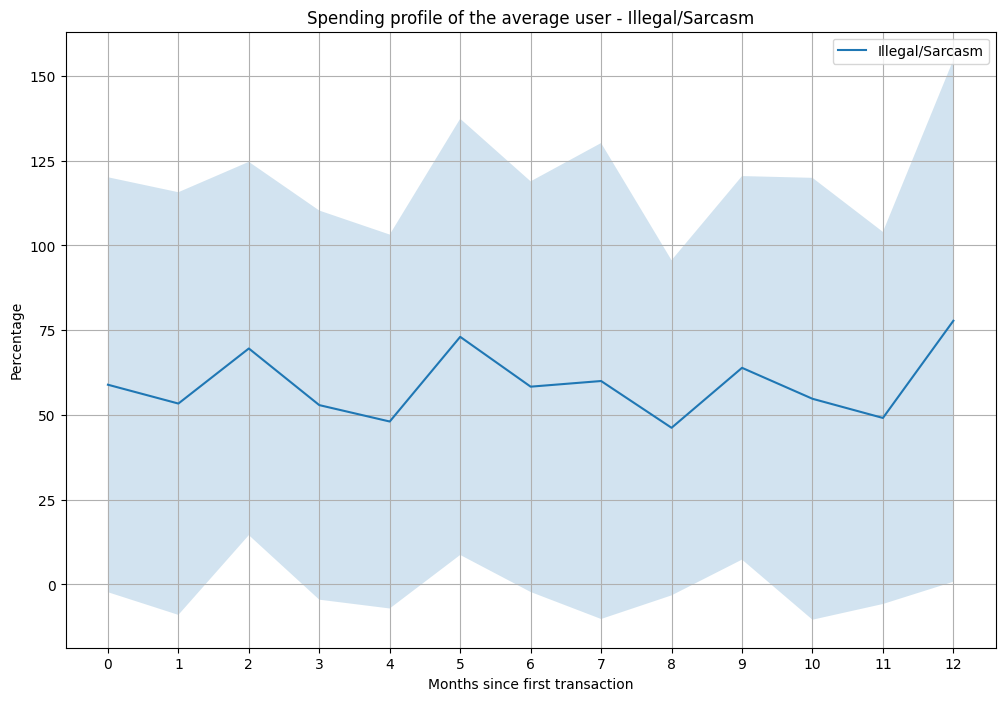

    months_since_first    average
61                   0  58.907880
62                   1  53.354701
63                   2  69.593254
64                   3  52.893773
65                   4  48.055556
66                   5  73.030303
67                   6  58.333333
68                   7  60.000000
69                   8  46.203704
70                   9  63.888889
71                  10  54.761905
72                  11  49.107143
73                  12  77.777778


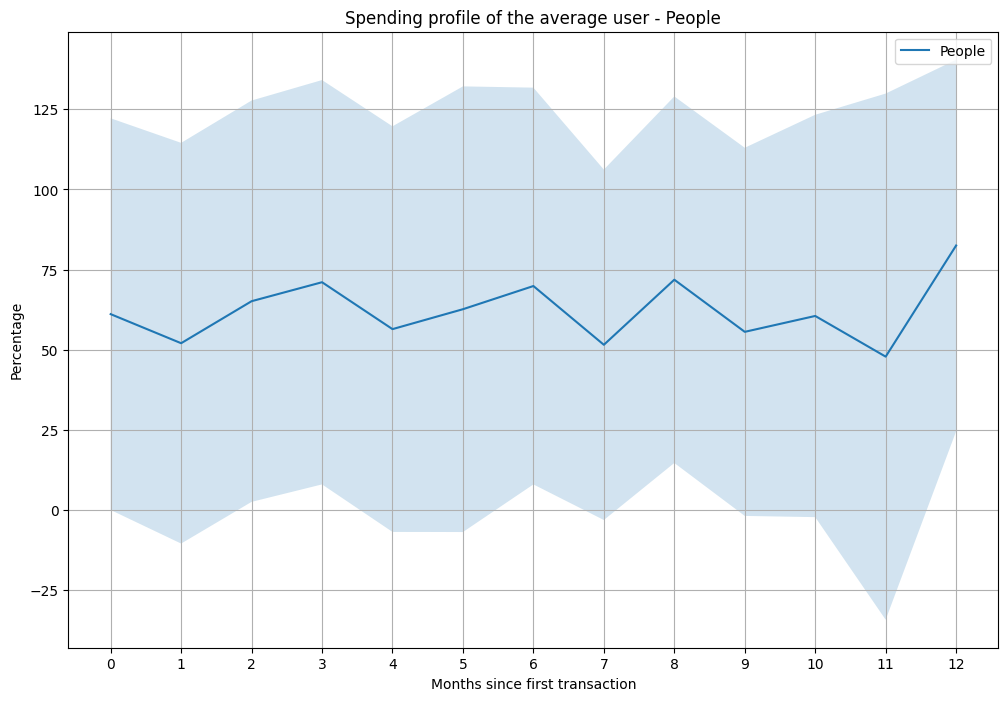

    months_since_first    average
74                   0  61.078685
75                   1  52.006803
76                   2  65.119048
77                   3  71.041667
78                   4  56.403509
79                   5  62.619048
80                   6  69.852941
81                   7  51.515152
82                   8  71.825397
83                   9  55.555556
84                  10  60.512821
85                  11  47.817460
86                  12  82.500000


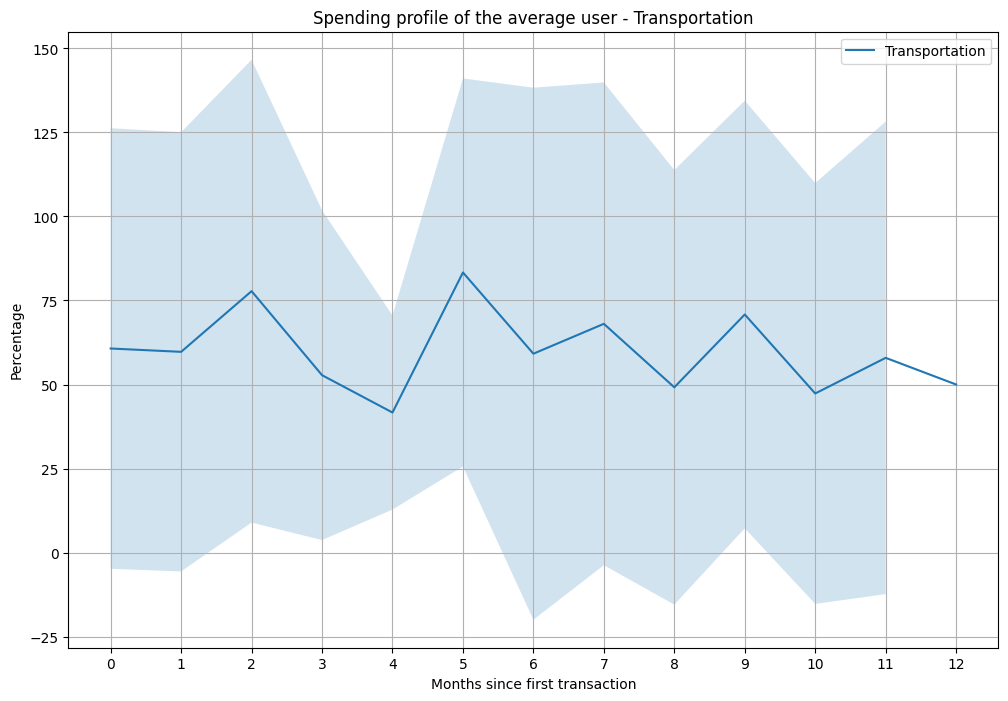

    months_since_first    average
87                   0  60.713860
88                   1  59.722222
89                   2  77.777778
90                   3  52.777778
91                   4  41.666667
92                   5  83.333333
93                   6  59.166667
94                   7  68.055556
95                   8  49.166667
96                   9  70.833333
97                  10  47.333333
98                  11  57.936508
99                  12  50.000000


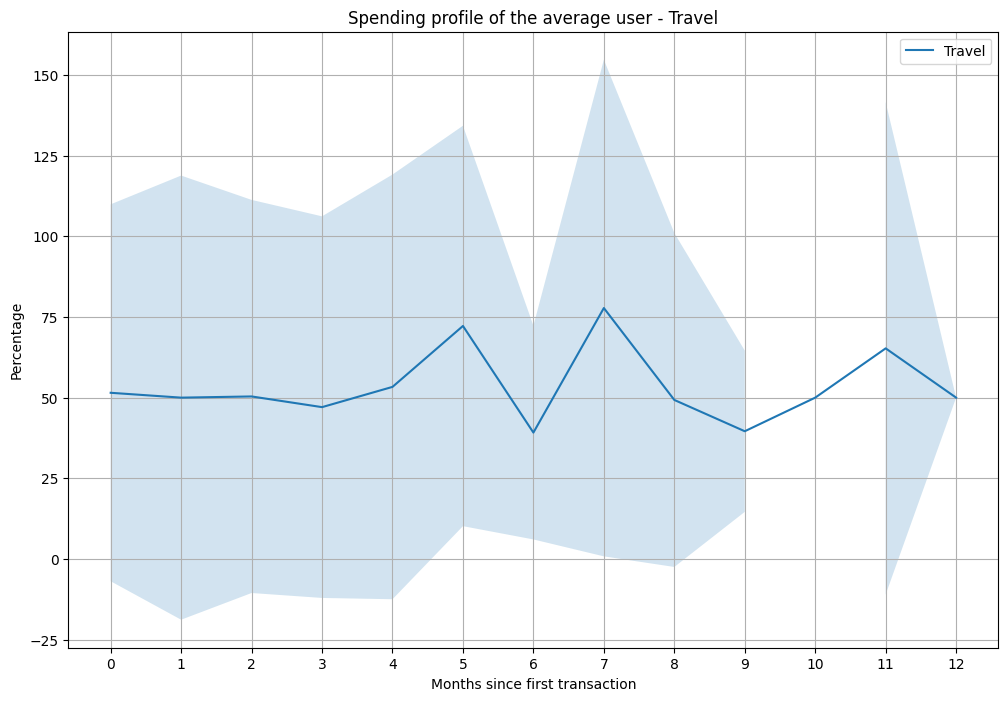

     months_since_first    average
100                   0  51.504723
101                   1  50.000000
102                   2  50.370370
103                   3  47.056277
104                   4  53.333333
105                   5  72.222222
106                   6  39.166667
107                   7  77.777778
108                   8  49.285714
109                   9  39.583333
110                  10  50.000000
111                  11  65.277778
112                  12  50.000000


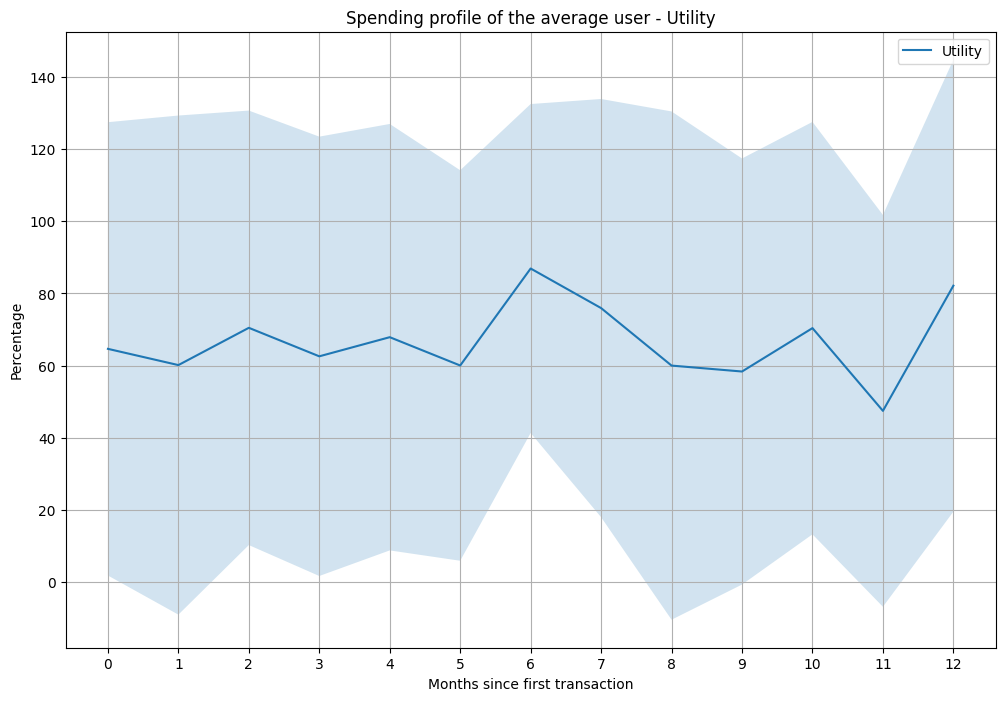

     months_since_first    average
113                   0  64.619764
114                   1  60.116959
115                   2  70.454545
116                   3  62.547619
117                   4  67.857143
118                   5  60.000000
119                   6  86.904762
120                   7  75.925926
121                   8  59.978632
122                   9  58.333333
123                  10  70.370370
124                  11  47.420635
125                  12  82.142857


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Pivot DataFrame to have months_since_first as index, text_category as columns, and average as values
average_df = avg_std_dev_per_month_pd.pivot_table(index="months_since_first", columns="text_category", values="average")

# Pivot DataFrame to have months_since_first as index, text_category as columns, and standard_deviation as values
std_dev_df = avg_std_dev_per_month_pd.pivot_table(index="months_since_first", columns="text_category", values="standard_deviation")

# For each category
for category in average_df.columns:
    # Create a new figure and axes for each category plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the average for the category with confidence interval (+- 2 * standard deviation)
    ax.plot(average_df.index, average_df[category], label=category)
    ax.fill_between(
        average_df.index,
        average_df[category] - 2 * std_dev_df[category],
        average_df[category] + 2 * std_dev_df[category],
        alpha=0.2
    )

    ax.set_xlabel("Months since first transaction")
    ax.set_ylabel("Percentage")
    ax.set_title(f"Spending profile of the average user - {category}")
    ax.legend()
    plt.xticks(np.arange(0, 13, step=1))  # Set x-axis ticks to display every month from 0 to 12
    plt.grid()
    plt.show()

    # Display the table for the category's percentage over time
    category_table = avg_std_dev_per_month_pd.loc[avg_std_dev_per_month_pd['text_category'] == category, ['months_since_first', 'average']]
    print(category_table)


# Social Network Analytics

### Q5 [10 pts]: Write a script to find a user’s friends and friends of friends (Friend definition: A user’s friend is someone who has transacted with the user, either sending money to the user or receiving money from the user). Describe your algorithm and calculate its computational complexity. Can you do it better?

In [86]:
final_df.printSchema()

root
 |-- user1: integer (nullable = true)
 |-- user2: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- story_id: string (nullable = true)
 |-- text_category: string (nullable = true)
 |-- emoji: string (nullable = true)
 |-- emoji_category: string (nullable = true)



In [87]:
final_df = final_df.sample(False, 0.1, seed=42) # change the percentage here

In [88]:
final_df.write.mode('overwrite').parquet("/content/drive/Shareddrives/Big Data Project/Homework/Venmo HW/final_df.parquet")

In [89]:
final_df.show(truncate=False)

+-------+-------+----------------+-------------------+--------------------------------------------------------------------------------------+-----------+------------------------+--------------+-----+--------------+
|user1  |user2  |transaction_type|datetime           |description                                                                           |is_business|story_id                |text_category |emoji|emoji_category|
+-------+-------+----------------+-------------------+--------------------------------------------------------------------------------------+-----------+------------------------+--------------+-----+--------------+
|2309177|1850775|charge          |2016-06-08 06:04:20|Ancient pair                                                                          |false      |575752f4cd03c9af22b199f5|Transportation|null |null          |
|5183325|3463466|payment         |2015-12-23 14:06:42|🍊                                                                                    |

In [90]:
from pyspark.sql import functions as F
# Group by user1 and user2 to get the minimum datetime for each user
first_transaction_dates = final_df.groupBy("user1").agg(F.min("datetime").alias("first_transaction"))

# Rename the columns for merging
first_transaction_dates = first_transaction_dates.withColumnRenamed("user1","user").withColumnRenamed("first_transaction","first_transaction_user")

In [91]:
# Join the first transaction dates back to the original DataFrame
df_with_lifetime = final_df.join(first_transaction_dates, final_df.user1 == first_transaction_dates.user, how='left')

# Calculate the "lifetime" of each transaction in months
df_with_lifetime = df_with_lifetime.withColumn("lifetime_months", 
                      (F.year(df_with_lifetime.datetime) - F.year(df_with_lifetime.first_transaction_user)) * 12 
                      + (F.month(df_with_lifetime.datetime) - F.month(df_with_lifetime.first_transaction_user)))

In [92]:
df_first_12_months = df_with_lifetime.filter(df_with_lifetime.lifetime_months <= 12)

In [93]:
df_first_12_months.show()

+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+---------------+-----+--------------+-------+----------------------+---------------+
|  user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|  text_category|emoji|emoji_category|   user|first_transaction_user|lifetime_months|
+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+---------------+-----+--------------+-------+----------------------+---------------+
| 219523|1288863|          charge|2015-04-29 12:50:56|Pge water maid fo...|      false|55407140e855747b2...|           Food| null|          null| 219523|   2015-04-29 12:50:56|              0|
| 360710| 167260|         payment|2013-06-29 04:01:26|              Vodkar|      false|51cdf67f7de518fa3...|           null| null|          null| 360710|   2013-06-29 04:01:26|              0|
| 377599|2331442|         payment|2

In [94]:
print(final_df.count())
print(df_first_12_months.count())

10889
10875


**To find friends of a user:**
friends = []
For record in dataframe:
  if user1 == user OR user2 == user:
    friends.append(other user)

get unique values from friends list

**To find friends of friends**
friends_of_friend = []
For user in friends:
  For record in dataframe:
    if user1 == user OR user2 == user:
      friends.append(other user)

get unique values from friends_of_friend list


$O(n^2)$

In [95]:
%%time
from pyspark.sql.functions import col

def find_all_friends(df):
    # Get all unique users
    unique_users = df.select("user1").union(df.select("user2")).distinct().collect()
    
    # Initialize the friends and friends of friends dictionaries
    friends_dict = {}
    friends_of_friends_dict = {}

    # Loop through each unique user
    for row in unique_users:
        user_id = row[0]

        # Find friends
        friends = find_friends(df, user_id)
        friends_dict[user_id] = friends

        # Find friends of friends
        friends_of_friends = find_friends_of_friends(df, friends)
        friends_of_friends_dict[user_id] = friends_of_friends

    return friends_dict, friends_of_friends_dict

def find_friends(df, user_id):
    friends = []
    for row in df.collect():
        if row['user1'] == user_id:
            friends.append(row['user2'])
        elif row['user2'] == user_id:
            friends.append(row['user1'])
    friends = list(set(friends))
    return friends

def find_friends_of_friends(df, friends):
    friends_of_friends = []
    for friend in friends:
        for row in df.collect():
            if row['user1'] == friend:
                friends_of_friends.append(row['user2'])
            elif row['user2'] == friend:
                friends_of_friends.append(row['user1'])
    friends_of_friends = list(set(friends_of_friends))
    return friends_of_friends

# friends_dict, friends_of_friends_dict = find_all_friends(df_first_12_months)


CPU times: user 29 µs, sys: 0 ns, total: 29 µs
Wall time: 44.3 µs


In [96]:
%%time
find_friends(df_first_12_months, 4892258)

CPU times: user 304 ms, sys: 25.2 ms, total: 329 ms
Wall time: 27.1 s


[]

In [97]:
%%time
find_friends_of_friends(df_first_12_months,find_friends(df_first_12_months, 4892258))

CPU times: user 290 ms, sys: 989 µs, total: 291 ms
Wall time: 1.69 s


[]

In [98]:
%%time
find_friends(df_first_12_months, 5697557)

CPU times: user 169 ms, sys: 3.96 ms, total: 173 ms
Wall time: 1.57 s


[]

The above algorithms have a Time Comlexity of $O(n^2)$ therefore we choose a different method.

In the code below we leverage spark to find the list of friends and friends of friends faster.

In [99]:
from pyspark.sql.functions import collect_list, size

# Create a new DataFrame with two columns: 'user' and 'friend'
df_friends = df_first_12_months.selectExpr("user1 as user", "user2 as friend").union(df_first_12_months.selectExpr("user2 as user", "user1 as friend"))

# Group by 'user' and aggregate the 'friend' column into a list and count the friends
df_friends_list = df_friends.groupBy('user').agg(collect_list('friend').alias('friends'), size(collect_list('friend')).alias('count_friends'))

In [100]:
from pyspark.sql.functions import explode, flatten, array_distinct

# Create a new DataFrame that maps each user to their friends of friends
df_friends_of_friends = df_friends_list \
    .withColumn('friend', explode('friends')) \
    .join(df_friends_list.withColumnRenamed('user', 'friend').withColumnRenamed('friends', 'friends_of_friend'), on='friend') \
    .groupBy('user') \
    .agg(collect_list('friends_of_friend').alias('friends_of_friends'))

# Flatten the list of friends of friends and remove duplicates
df_friends_of_friends = df_friends_of_friends \
    .withColumn('friends_of_friends', array_distinct(flatten('friends_of_friends')))

# Calculate the count of friends of friends
df_friends_of_friends = df_friends_of_friends \
    .withColumn('count_friends_of_friends', size('friends_of_friends'))

# Join back with df_friends_list to add the friends of friends list and the count
df_friends_list = df_friends_list \
    .join(df_friends_of_friends, on='user', how='left_outer')

### Q6 [20 pts]: Now, that you have the list of each user’s friends and friends of friends, you are in position to calculate many social network variables. Use the dynamic analysis from before, and calculate the following social network metrics across a user’s lifetime in Venmo (from 0 up to 12 months).

### i) Number of friends and number of friends of friends [very easy, 4 pts].

In [101]:
df_friends_list.show(5)

+------+---------+-------------+------------------+------------------------+
|  user|  friends|count_friends|friends_of_friends|count_friends_of_friends|
+------+---------+-------------+------------------+------------------------+
|219523|[1288863]|            1|          [219523]|                       1|
|351750|[2372811]|            1|          [351750]|                       1|
|360710| [167260]|            1|          [360710]|                       1|
|377599|[2331442]|            1|          [377599]|                       1|
|402253| [993909]|            1|          [402253]|                       1|
+------+---------+-------------+------------------+------------------------+
only showing top 5 rows



In [102]:
# df_first_12_months.show(5)
rows = df_friends_list.take(5)
for row in rows:
    print(row)
# df_limited = df_first_12_months.limit(1000)  # Only consider the first 1000 rows
# df_limited.show(5)

Row(user=219523, friends=[1288863], count_friends=1, friends_of_friends=[219523], count_friends_of_friends=1)
Row(user=351750, friends=[2372811], count_friends=1, friends_of_friends=[351750], count_friends_of_friends=1)
Row(user=360710, friends=[167260], count_friends=1, friends_of_friends=[360710], count_friends_of_friends=1)
Row(user=377599, friends=[2331442], count_friends=1, friends_of_friends=[377599], count_friends_of_friends=1)
Row(user=402253, friends=[993909], count_friends=1, friends_of_friends=[402253], count_friends_of_friends=1)


### ii) Clustering coefficient of a user's network [easy, 6 pts]. (Hint: the easiest way to calculate this is to program it yourselves. Alternatively, you can use “networkx” python package. The latter approach will slow down your script significantly).

### The graph would be considered undirected for this purpose

1. Identify the friends and store in a friend list - length of N.

2. Calculate the potential number of connections that are possible between these friends - N*(N-1)/2.

3. For each friend in the friend list - see if the friend has any of the og guys friends in his friends.

The algorithm above would have a time complexity of $O(n^2)$ again, thefore we once again leverage Spark to calculate the clustering coefficients of each user quiker.

In [103]:
from pyspark.sql.functions import col, count

# Explode the 'friends' column into separate rows
df_exploded = df_friends_list.select('user', explode('friends').alias('friend'))

# Self-join the DataFrame on the 'user' column to find all pairs of friends for each user
df_pairs = df_exploded.alias('a').join(df_exploded.alias('b'), col('a.user') == col('b.user'))

# Count the number of connections between friends for each user
df_connections = df_pairs.where(col('a.friend') < col('b.friend')).groupBy('a.user').agg(count('*').alias('connections'))

# Calculate the total possible number of connections between friends for each user
df_possible_connections = df_friends_list.select('user', (col('count_friends')*(col('count_friends')-1)/2).alias('possible_connections'))

# Join the DataFrames and calculate the clustering coefficient
df_clustering_coefficient = df_connections.join(df_possible_connections, on='user')
df_clustering_coefficient = df_clustering_coefficient.withColumn('clustering_coefficient', col('connections')/col('possible_connections'))

# Join back with df_friends_list to add the clustering coefficient
df_friends_list = df_friends_list.join(df_clustering_coefficient.select('user', 'clustering_coefficient'), on='user', how='left_outer')


In [104]:
df_friends_list.show(5)

+------+---------+-------------+------------------+------------------------+----------------------+
|  user|  friends|count_friends|friends_of_friends|count_friends_of_friends|clustering_coefficient|
+------+---------+-------------+------------------+------------------------+----------------------+
|219523|[1288863]|            1|          [219523]|                       1|                  null|
|351750|[2372811]|            1|          [351750]|                       1|                  null|
|360710| [167260]|            1|          [360710]|                       1|                  null|
|377599|[2331442]|            1|          [377599]|                       1|                  null|
|402253| [993909]|            1|          [402253]|                       1|                  null|
+------+---------+-------------+------------------+------------------------+----------------------+
only showing top 5 rows



In [105]:
rows = df_friends_list.take(5)
for row in rows:
    print(row)

Row(user=219523, friends=[1288863], count_friends=1, friends_of_friends=[219523], count_friends_of_friends=1, clustering_coefficient=None)
Row(user=351750, friends=[2372811], count_friends=1, friends_of_friends=[351750], count_friends_of_friends=1, clustering_coefficient=None)
Row(user=360710, friends=[167260], count_friends=1, friends_of_friends=[360710], count_friends_of_friends=1, clustering_coefficient=None)
Row(user=377599, friends=[2331442], count_friends=1, friends_of_friends=[377599], count_friends_of_friends=1, clustering_coefficient=None)
Row(user=402253, friends=[993909], count_friends=1, friends_of_friends=[402253], count_friends_of_friends=1, clustering_coefficient=None)


Clustering Coefficient using networkx package

In [106]:
# import networkx as nx
# from pyspark.sql.functions import col

# def calculate_clustering_coefficient_networkx(df):
#     # Create an empty graph
#     g = nx.Graph()

#     # Add nodes and edges to the graph
#     for row in df.collect():
#         g.add_edge(row['user1'], row['user2'])

#     # Get all unique users from user1 and user2 columns
#     unique_users = df.select("user1").union(df.select("user2")).distinct()

#     # Initialize an empty dictionary to store the clustering coefficients
#     clustering_coefficients = {}

#     # Iterate over each unique user
#     for row in unique_users.collect():
#         user_id = row[0]

#         # Calculate the clustering coefficient
#         cc = nx.clustering(g, user_id)

#         # Store the clustering coefficient
#         clustering_coefficients[user_id] = cc

#     return clustering_coefficients

# clustering_coefficients = calculate_clustering_coefficient_networkx(df_first_12_months)

In [107]:
# clustering_coefficients[4892258]

### iii) Calculate the page rank of each user (hard, 10 pts). (Hint: First of all, you need to use GraphFrames to do this. Moreover, notice that page rank is a global social network metric. If you go ahead and calculate the page rank for each user at each of her lifetime points, you will soon realize it will be a dead end. Can you think of a smart way to do this?)

In [108]:
#spark2 = SparkSession.builder.master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.8.1-spark3.0-s_2.12").getOrCreate()
from graphframes import *

# Create a GraphFrame
# First, create a Vertex DataFrame
v = df_first_12_months.selectExpr("user1 as id").distinct().union(df_first_12_months.selectExpr("user2 as id").distinct())

# Second, create an Edge DataFrame
e = df_first_12_months.selectExpr("user1 as src", "user2 as dst")

# Create a GraphFrame
g = GraphFrame(v, e)

# Run PageRank algorithm, and select only the columns "id" and "pagerank"
results = g.pageRank(resetProbability=0.15, tol=0.01).vertices.select("id", "pagerank")

# Rename the columns to "user" and "pagerank" for consistency
results = results.withColumnRenamed("id", "user")

# Join back with df_friends_list to add the pagerank
df_friends_list = df_friends_list.join(results, on='user', how='left_outer')

In [109]:
df_friends_list.show()

+-------+------------------+-------------+------------------+------------------------+----------------------+------------------+
|   user|           friends|count_friends|friends_of_friends|count_friends_of_friends|clustering_coefficient|          pagerank|
+-------+------------------+-------------+------------------+------------------------+----------------------+------------------+
| 219523|         [1288863]|            1|          [219523]|                       1|                  null|0.6986984661425121|
| 351750|         [2372811]|            1|          [351750]|                       1|                  null|1.2925921623636472|
| 360710|          [167260]|            1|          [360710]|                       1|                  null|0.6986984661425121|
| 377599|         [2331442]|            1|          [377599]|                       1|                  null|0.6986984661425121|
| 402253|          [993909]|            1|          [402253]|                       1|           

In [111]:
df_friends_list.write.mode('overwrite').parquet("/content/drive/Shareddrives/Big Data Project/Homework/Venmo HW/df_friends_list.parquet", )

In [112]:
# from graphframes import GraphFrame

# distinct_user1 = df_first_12_months.select(col("user1")).distinct()
# distinct_user2 = df_first_12_months.select(col("user2")).distinct()

# vertices = distinct_user1.union(distinct_user2).distinct().toDF("id")
# edges = df_first_12_months.select(col("user1"), col("user2")).distinct().toDF("src","dst")

# # Create a GraphFrame
# graph = GraphFrame(vertices, edges)

# # Run PageRank algorithm
# pagerank = graph.pageRank(tol=0.001)

# # Get the PageRank values
# pagerank_vertices = pagerank.vertices

# # Show the PageRank results
# pagerank_vertices.show()

With each update of the social network there is a probability that the page rank of the user changes. In such a case we would have to constantly update the page rank of each user at each change to the network. This would be chaotic and computationally intensive. 

Instead, we just calculate the page rank for each user once in this case - at the end of a give time period to estimate the influence of the user in proportion to the entire netowrk. However, this leads to a loss of understanding to how important of a role a particular user played at a particular moment of time.

# Creating new spark environment as we were facing heap memory issues

We have commented this part out as it is only needed if you are unable to run the code end to end 

In [ ]:
# # Run below commands
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz
# !tar xf spark-3.0.3-bin-hadoop3.2.tgz
# !pip install -q findspark

In [ ]:
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"

In [ ]:
# import findspark
# findspark.init()
# from pyspark.sql import SparkSession
# from pyspark import SparkConf, SparkContext
# from datetime import datetime, date, timedelta
# from dateutil import relativedelta
# from pyspark.sql import SQLContext, Row
# from pyspark.sql.types import *
# from pyspark.sql.functions import *
# from pyspark.sql import DataFrame
# from pyspark.sql.functions import *
# from pyspark.sql.functions import to_timestamp, to_date, dayofmonth
# from pyspark.sql import functions as F  
# from pyspark.sql.functions import collect_list, collect_set, concat, first, array_distinct, col, size, expr
# from pyspark.sql import DataFrame 
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.evaluation import RegressionEvaluator
# import random

In [ ]:
# # Initialize Spark session
# #spark = SparkSession.builder.master("local").appName("Venmo").getOrCreate()

# spark = SparkSession.builder.master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.8.1-spark3.0-s_2.12").appName("Venmo").getOrCreate()

# df_friends_list = spark.read.parquet("/content/drive/Shareddrives/Big Data Project/Homework/Venmo HW/df_friends_list.parquet")
# final_df = spark.read.parquet("/content/drive/Shareddrives/Big Data Project/Homework/Venmo HW/final_df.parquet")
# # emoji_dictionary_df = spark.read.csv("/content/drive/Shareddrives/Big Data Project/Homework/Venmo HW/Venmo_Emoji_Classification_Dictionary.csv", header=True)

In [ ]:
# df_friends_list.show()

+------+------------------+-------------+------------------+------------------------+----------------------+------------------+
|  user|           friends|count_friends|friends_of_friends|count_friends_of_friends|clustering_coefficient|          pagerank|
+------+------------------+-------------+------------------+------------------------+----------------------+------------------+
| 90882|          [258641]|            1|           [90882]|                       1|                  null|1.2925921623636472|
|122033|          [864071]|            1|  [212128, 122033]|                       2|                  null|0.6986984661425121|
|162447|          [150413]|            1|          [162447]|                       1|                  null|0.6986984661425121|
|173103|         [6871306]|            1|          [173103]|                       1|                  null|1.2925921623636472|
|190095|          [129520]|            1|          [190095]|                       1|                  n

# Predictive Analytics with Mlib

##**Q7**

 First, create your dependent variable Y, i.e. the total number of transactions at lifetime point 12. In other words, for every user, you need to count how many transactions s/he had committed during her/his twelve months in Venmo.

In [ ]:
final_df.show(truncate=False)

+-------+-------+----------------+-------------------+-----------------------------------------------------------------------------------+-----------+------------------------+---------------+-----+--------------+
|user1  |user2  |transaction_type|datetime           |description                                                                        |is_business|story_id                |text_category  |emoji|emoji_category|
+-------+-------+----------------+-------------------+-----------------------------------------------------------------------------------+-----------+------------------------+---------------+-----+--------------+
|1069346|3543226|charge          |2015-10-07 10:26:29|Pay yo bills                                                                       |false      |561490e5cd03c9af22961688|Utility        |null |null          |
|3410728|2233850|payment         |2016-01-31 14:09:24|🙃                                                                                 |false      

In [ ]:
# Get the size of the DataFrame
row_count = final_df.count()
column_count = len(final_df.columns)

# Print the size
print("Number of rows: {}".format(row_count))
print("Number of columns: {}".format(column_count))

Number of rows: 10889
Number of columns: 10


In [ ]:
# Extract the month from datetime column
df_with_month = final_df.withColumn("month", month(final_df["datetime"]))

# Show the result
#df_with_month.show()

In [ ]:
##Creating Y =total no of transactions at lifepoint 12

# Group by columns user1 and month and get the no of transactions
grouped_df = df_with_month.groupBy("user1", "month").agg(count("*").alias("transaction_count"))

# Show the result
#grouped_df.show()

In [ ]:
# Sort the DataFrame by month column in descending order
sorted_df = grouped_df.orderBy(desc("transaction_count"))

# Show the result
#sorted_df.show()

##**Q8**

Recency refers to the last time a user was active, and frequency is how often a user uses Venmo in a month.

Create the recency and frequency variables. In CRM, this predictive framework is
known as RFM. Here, you don’t have monetary amounts, so we will focus on just RF. Recency
refers to the last time a user was active, and frequency is how often a user uses Venmo in a
month. You need to compute these metrics across a user’s lifetime in Venmo (from 0 up to 12).
For example, if a user has used Venmo twice during her first month in Venmo with the second
time being on day x, then her recency in month 1 is “30-x” and her frequency is 30/2=15

In [ ]:
#Get the maximum datetime grouped by user1 and month
max_datetime_df = df_with_month.groupBy("user1", "month").agg(max("datetime").alias("max_datetime"))

# Show the result
#max_datetime_df.show()

In [ ]:
#removing extra month column
max_datetime_df = max_datetime_df.drop("month")

# Show the result
#max_datetime_df.show()

In [ ]:
# Join the DataFrames on column user1
joined_df = sorted_df.join(max_datetime_df, "user1")

# Show the result
#joined_df.show()

In [ ]:
# Sort the DataFrame by transaction count in descending order
joined_df = joined_df.orderBy(desc("transaction_count"))

# Show the result
#joined_df.show()

In [ ]:
# Extract the date from max datetime column
df_with_date = joined_df.withColumn("max_dayofmonth", dayofmonth(joined_df["max_datetime"]))

# Show the result
#df_with_date.show()

In [ ]:
# Recency calculation 
df_recency = df_with_date.withColumn("Recency", 30-df_with_date['max_dayofmonth'])

# Show the result
#df_recency.show()


In [ ]:
# Frequency Calculation
df_freq = df_recency.withColumn("Frequency", round(30/df_recency['transaction_count'],2))

# Show the result
#df_freq.show()

In [ ]:
# Sort the DataFrame by month column in descending order
df_pred = df_freq.orderBy(desc("user1"))

# Show the result
#df_pred.show()

##**Q9**

For each user’s lifetime point, regress recency and frequency on Y. 
Plot the MSE for each lifetime point. In other words, your x-axis will be lifetime in months (0-12), and your
y-axis will be the MSE. (Hint: Don’t forget to split your data into train and test sets)

In [ ]:
# Assemble the features vector
assembler = VectorAssembler(inputCols=["Recency", "Frequency"], outputCol="features")
assembled_df = assembler.transform(df_pred)

# Split the data into train and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Create the LinearRegression model
lr = LinearRegression(featuresCol="features", labelCol="transaction_count")

# Fit the model to the data
model = lr.fit(train_data)

# Print the coefficients
intercept = model.intercept
coefficients = model.coefficients
print("Intercept: {}".format(intercept))
print("Coefficients: {}".format(coefficients))

Intercept: 3.3863074104587136
Coefficients: [3.2919035483552614e-05,-0.07968813228866214]


In [ ]:
# Looping through every month to find predicted value and mse

# Create an empty list to store the values
month_list = []
mse_list = []

for value in range(1, 13):
    #storing month number in list
    month_list.append(value)
    # Filtering test data for each month
    test_data_value = test_data.filter(test_data['month'] == value)
    # Predcited values with test data
    predictions_value = model.transform(test_data_value)
    # Calculate MSE
    evaluator = RegressionEvaluator(labelCol="transaction_count", predictionCol="prediction", metricName="mse")
    mse_value = evaluator.evaluate(predictions_value)
    print(f"mse for month {value} is {mse_value}")
    mse_list.append(mse_value)



print(month_list)
print(mse_list)

mse for month 1 is 0.0009494732433410337
mse for month 2 is 0.020599051516375585
mse for month 3 is 0.009365139809826001
mse for month 4 is 0.0022454567288860898
mse for month 5 is 0.0041431987904960044
mse for month 6 is 0.003382770023065518
mse for month 7 is 0.0017909005210750084
mse for month 8 is 0.11113946932355533
mse for month 9 is 0.12150638158889356
mse for month 10 is 0.004711361665142231
mse for month 11 is 0.004496538698806977
mse for month 12 is 0.004556805747008272
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0.0009494732433410337, 0.020599051516375585, 0.009365139809826001, 0.0022454567288860898, 0.0041431987904960044, 0.003382770023065518, 0.0017909005210750084, 0.11113946932355533, 0.12150638158889356, 0.004711361665142231, 0.004496538698806977, 0.004556805747008272]


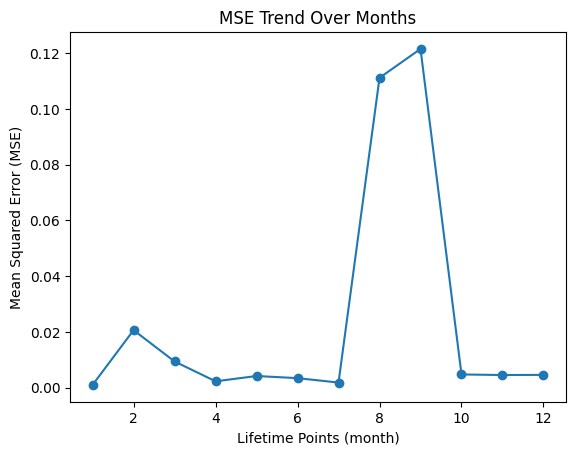

In [ ]:
import matplotlib.pyplot as plt

# Plot MSE vs lifetime points

# Plot the line chart
plt.plot(month_list, mse_list, marker='o', linestyle='-')

# Set the labels for x-axis and y-axis
plt.xlabel('Lifetime Points (month)')
plt.ylabel('Mean Squared Error (MSE)')

# Set the title of the chart
plt.title('MSE Trend Over Months')

# Show the chart
plt.show()

##**Q10**

For each user’s lifetime point, regress recency, frequency AND her spending
behavior profile on Y. Plot the MSE for each lifetime point like above. Did you get any improvement?

In [ ]:
df_with_month.show(truncate=False)

+-------+-------+----------------+-------------------+-----------------------------------------------------------------------------------+-----------+------------------------+---------------+-----+--------------+-----+
|user1  |user2  |transaction_type|datetime           |description                                                                        |is_business|story_id                |text_category  |emoji|emoji_category|month|
+-------+-------+----------------+-------------------+-----------------------------------------------------------------------------------+-----------+------------------------+---------------+-----+--------------+-----+
|1069346|3543226|charge          |2015-10-07 10:26:29|Pay yo bills                                                                       |false      |561490e5cd03c9af22961688|Utility        |null |null          |10   |
|3410728|2233850|payment         |2016-01-31 14:09:24|🙃                                                                     

In [ ]:
# Pivot the column and count occurrences
pivoted_df = df_with_month.groupBy('user1', 'month').pivot("text_category").count()

# Get the distinct values in the column_to_pivot
distinct_values = df_with_month.select("text_category").distinct().rdd.flatMap(lambda x: x).collect()

# Fill missing values with 0
pivoted_df = pivoted_df.na.fill(0)

# Rename the columns
for value in distinct_values:
    pivoted_df = pivoted_df.withColumnRenamed(value, "count_{}".format(value))

# Show the result
#pivoted_df.show()

In [ ]:
# joining with df_pred

df_pred_text = df_pred.join(pivoted_df, ["user1", "month"])

# Show the result
#df_pred_text.show()

In [ ]:
# Assemble the features vector
assembler = VectorAssembler(inputCols=["Recency", "Frequency", "count_Activity", "count_Cash", "count_Event", "count_Food", "count_Illegal/Sarcasm", "count_People", "count_Transportation", "count_Travel", "count_Utility"], outputCol="features")
assembled_df = assembler.transform(df_pred_text)

# Split the data into train and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Create the LinearRegression model
lr = LinearRegression(featuresCol="features", labelCol="transaction_count")

# Fit the model to the data
model = lr.fit(train_data)

# Print the coefficients
intercept = model.intercept
coefficients = model.coefficients
print("Intercept: {}".format(intercept))
print("Coefficients: {}".format(coefficients))

Intercept: 3.4333437015041097
Coefficients: [0.00013326618241774348,-0.0815353345383979,0.02264957672839509,0.031236481637175923,-0.0032270200697511386,0.006135145341188664,0.03275348756409279,-0.013303196215429594,0.003519061682498514,0.010793529880729487,0.023248639867508386]


In [ ]:
# Looping through every month to find predicted value and mse

# Create an empty list to store the values
month_list = []
mse_list = []

for value in range(1, 13):
    #storing month number in list
    month_list.append(value)
    # Filtering test data for each month
    test_data_value = test_data.filter(test_data['month'] == value)
    # Predcited values with test data
    predictions_value = model.transform(test_data_value)
    # Calculate MSE
    evaluator = RegressionEvaluator(labelCol="transaction_count", predictionCol="prediction", metricName="mse")
    mse_value = evaluator.evaluate(predictions_value)
    print(f"mse for month {value} is {mse_value}")
    mse_list.append(mse_value)



print(month_list)
print(mse_list)

mse for month 1 is 0.002113945531282534
mse for month 2 is 0.006056137922865016
mse for month 3 is 0.005074381539964212
mse for month 4 is 0.0033420748276681627
mse for month 5 is 0.004610474423832925
mse for month 6 is 0.003576246849050491
mse for month 7 is 0.0041490030084624175
mse for month 8 is 0.011458262150729448
mse for month 9 is 0.003710664703886499
mse for month 10 is 0.013134897537975756
mse for month 11 is 0.01505175936505958
mse for month 12 is 0.007632377636342771
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0.002113945531282534, 0.006056137922865016, 0.005074381539964212, 0.0033420748276681627, 0.004610474423832925, 0.003576246849050491, 0.0041490030084624175, 0.011458262150729448, 0.003710664703886499, 0.013134897537975756, 0.01505175936505958, 0.007632377636342771]


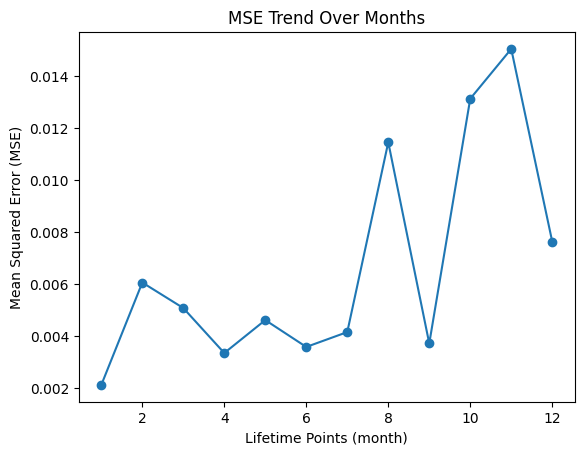

In [ ]:
import matplotlib.pyplot as plt

# Plot MSE vs lifetime points

# Plot the line chart
plt.plot(month_list, mse_list, marker='o', linestyle='-')

# Set the labels for x-axis and y-axis
plt.xlabel('Lifetime Points (month)')
plt.ylabel('Mean Squared Error (MSE)')

# Set the title of the chart
plt.title('MSE Trend Over Months')

# Show the chart
plt.show()

##**Q10**

For each user’s lifetime point, regress her social network metrics on Y. Plot the MSE for each lifetime point like above. What do you observe? How do social network metrics compare with the RF framework? What are the most informative predictors?

In [ ]:
#df_friends_list.show()

In [ ]:
#converting Null to 0
df_friends_list= df_friends_list.fillna(0)

In [ ]:
df_network = df_friends_list.drop("friends", "friends_of_friends")
#df_network.show()

In [ ]:
## Updating column name from user to user1 for joining with pred_df
df_network = df_network.withColumnRenamed("user", "user1")
#df_network.show()


In [ ]:
# Get the number of rows
num_rows = df_network.count()

# Get the number of columns
num_cols = len(df_network.columns)

# Print the size of the DataFrame
print("Number of rows: {}".format(num_rows))
print("Number of columns: {}".format(num_cols))

Number of rows: 19705
Number of columns: 5


In [ ]:
# Get the number of rows
num_rows = df_pred.count()

# Get the number of columns
num_cols = len(df_pred.columns)

# Print the size of the DataFrame
print("Number of rows: {}".format(num_rows))
print("Number of columns: {}".format(num_cols))

Number of rows: 10227
Number of columns: 7


In [ ]:
#df_pred.collect()
#df_network.collect()

In [ ]:
# Joining Datasets
df_pred_network = df_pred.join(df_network, on="user1", how="inner")

# Show the result
#df_pred_network.show()

In [ ]:
# Assemble the features vector
assembler = VectorAssembler(inputCols=["count_friends", "count_friends_of_friends", "clustering_coefficient", "pagerank"], outputCol="features")
assembled_df = assembler.transform(df_pred_network)

# Split the data into train and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Create the LinearRegression model
lr = LinearRegression(featuresCol="features", labelCol="transaction_count")

# Fit the model to the data
model = lr.fit(train_data)

# Print the coefficients
intercept = model.intercept
coefficients = model.coefficients
print("Intercept: {}".format(intercept))
print("Coefficients: {}".format(coefficients))

Intercept: 0.3317377380453105
Coefficients: [0.7878296005164971,0.007106479023430717,-0.8984814957088727,-0.1656349448057866]


In [ ]:
# Looping through every month to find predicted value and mse

# Create an empty list to store the values
month_list = []
mse_list = []

for value in range(1, 13):
    #storing month number in list
    month_list.append(value)
    # Filtering test data for each month
    test_data_value = test_data.filter(test_data['month'] == value)
    # Predcited values with test data
    predictions_value = model.transform(test_data_value)
    # Calculate MSE
    evaluator = RegressionEvaluator(labelCol="transaction_count", predictionCol="prediction", metricName="mse")
    mse_value = evaluator.evaluate(predictions_value)
    print(f"mse for month {value} is {mse_value}")
    mse_list.append(mse_value)



print(month_list)
print(mse_list)

mse for month 1 is 0.0017136269723059079
mse for month 2 is 0.00974311110596559
mse for month 3 is 0.010726703383065079
mse for month 4 is 0.016762519831248972
mse for month 5 is 0.02772364474519614
mse for month 6 is 0.003744553812233326
mse for month 7 is 0.004636949454117499
mse for month 8 is 0.006361967137133656
mse for month 9 is 0.0029939461558224755
mse for month 10 is 0.004963366212059271
mse for month 11 is 0.0768305691623244
mse for month 12 is 0.021871529152360177
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0.0017136269723059079, 0.00974311110596559, 0.010726703383065079, 0.016762519831248972, 0.02772364474519614, 0.003744553812233326, 0.004636949454117499, 0.006361967137133656, 0.0029939461558224755, 0.004963366212059271, 0.0768305691623244, 0.021871529152360177]


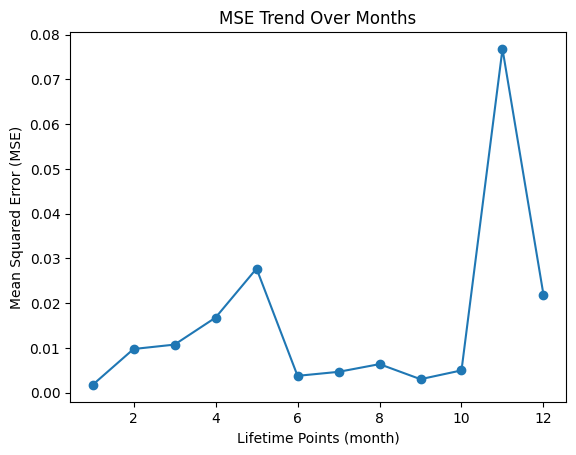

In [ ]:
import matplotlib.pyplot as plt

# Plot MSE vs lifetime points

# Plot the line chart
plt.plot(month_list, mse_list, marker='o', linestyle='-')

# Set the labels for x-axis and y-axis
plt.xlabel('Lifetime Points (month)')
plt.ylabel('Mean Squared Error (MSE)')

# Set the title of the chart
plt.title('MSE Trend Over Months')

# Show the chart
plt.show()

**What do you observe? How do social network metrics compare with the RF framework? What are the most informative predictors?**

The MSE error range for regression with social network metrics is lower as compared to the MSE range for RF Framework So the network analytics columns are more informative. 

##**Q11**

For each user’s lifetime point, regress her social network metrics and the
spending behavior of her social network on Y. Plot the MSE for each lifetime point like above. Does the spending behavior of her social network add any predictive benefit compared to Q10?

In [ ]:
# Collecting all values for df_pred_text
#df_pred_text.collect()

In [ ]:
# Joining Datasets
df_text_network = df_pred_text.join(df_network, on="user1", how="inner")

# Show the result
#df_text_network.show()

In [ ]:
# Assemble the features vector
assembler = VectorAssembler(inputCols=["count_friends", "count_friends_of_friends", "clustering_coefficient", "pagerank", "Recency", "Frequency", "count_Activity", "count_Cash", "count_Event", "count_Food", "count_Illegal/Sarcasm", "count_People", "count_Transportation", "count_Travel", "count_Utility"], outputCol="features")
assembled_df = assembler.transform(df_text_network)

# Split the data into train and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Create the LinearRegression model
lr = LinearRegression(featuresCol="features", labelCol="transaction_count")

# Fit the model to the data
model = lr.fit(train_data)

# Print the coefficients
intercept = model.intercept
coefficients = model.coefficients
print("Intercept: {}".format(intercept))
print("Coefficients: {}".format(coefficients))

Intercept: 2.09499560359557
Coefficients: [0.3973049489456425,0.0028459247866321597,-0.4453697831011821,-0.08731993447756362,0.0001730677351077903,-0.04809337942848068,0.012621270057482035,-0.027623691395612198,0.0009217394138630496,-0.0008924336040516191,0.0209427713362618,-0.007191311720992039,-0.0056353428243859655,0.004958168825578804,0.0022716285332465085]


In [ ]:
# Looping through every month to find predicted value and mse

# Create an empty list to store the values
month_list = []
mse_list = []

for value in range(1, 13):
    #storing month number in list
    month_list.append(value)
    # Filtering test data for each month
    test_data_value = test_data.filter(test_data['month'] == value)
    # Predcited values with test data
    predictions_value = model.transform(test_data_value)
    # Calculate MSE
    evaluator = RegressionEvaluator(labelCol="transaction_count", predictionCol="prediction", metricName="mse")
    mse_value = evaluator.evaluate(predictions_value)
    print(f"mse for month {value} is {mse_value}")
    mse_list.append(mse_value)



print(month_list)
print(mse_list)

mse for month 1 is 0.0006317596902647039
mse for month 2 is 0.0029796496976075403
mse for month 3 is 0.00563790639827166
mse for month 4 is 0.004422950031777603
mse for month 5 is 0.008937024458341323
mse for month 6 is 0.001174853730712441
mse for month 7 is 0.0016480832412372444
mse for month 8 is 0.004052762004834697
mse for month 9 is 0.0012003611276543687
mse for month 10 is 0.004602559566418186
mse for month 11 is 0.017878602779109087
mse for month 12 is 0.020359400054697177
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0.0006317596902647039, 0.0029796496976075403, 0.00563790639827166, 0.004422950031777603, 0.008937024458341323, 0.001174853730712441, 0.0016480832412372444, 0.004052762004834697, 0.0012003611276543687, 0.004602559566418186, 0.017878602779109087, 0.020359400054697177]


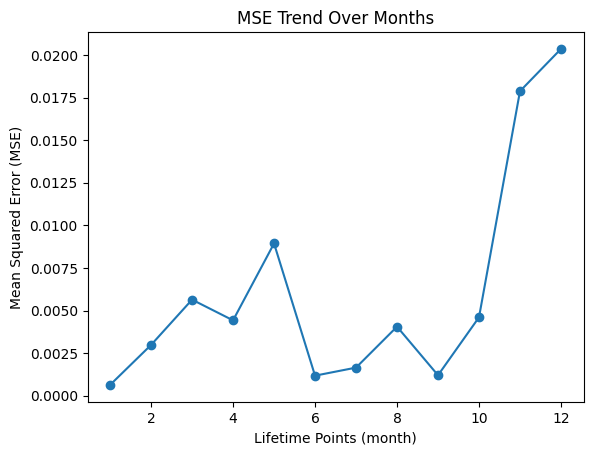

In [ ]:
import matplotlib.pyplot as plt

# Plot MSE vs lifetime points

# Plot the line chart
plt.plot(month_list, mse_list, marker='o', linestyle='-')

# Set the labels for x-axis and y-axis
plt.xlabel('Lifetime Points (month)')
plt.ylabel('Mean Squared Error (MSE)')

# Set the title of the chart
plt.title('MSE Trend Over Months')

# Show the chart
plt.show()

**Does the spending behavior of her social network add any predictive benefit compared to Q10?**

Yes, including network and spending behaviour reduces MSE, hence improving predictive power of the model.

